# ДЗ 4. Тематическое моделирование

Взять ноутбук с вебинара изменить тематики (минимум 3-ри тематики взять) построить тематическую модель, попробовать проинтерпретировать полученные тематики. Насколько они похожи на то что вы выделяли из корпуса. Возможно большее количество тематик так же хорошо интерпретируется проверьте это. Подберите оптимальное количество тематик с точки зрения интерпретации результатов. Не забывайте чтобы получить хорошие тематики надо хорошо почистить тексты.  

Построим тематические модели для корпуса новостей Lenta.ru, с которым мы уже работали ранее.

In [47]:
import pandas as pd
import numpy as np
import re

from corus import load_lenta

from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
import pymorphy2

from gensim.models import *
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
%matplotlib inline

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vlad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Распаковка и обзор данных

In [16]:
path = 'data/lenta-ru-news.csv.gz'
records = load_lenta(path)
next(records)

LentaRecord(
    url='https://lenta.ru/news/2018/12/14/cancer/',
    title='Названы регионы России с\xa0самой высокой смертностью от\xa0рака',
    text='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.',
    topic='Россия',
    tags='Общество',
    date=None
)

In [17]:
data = [(record.title, record.topic, record.text, record.tags) for record in records]

In [18]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
data = pd.DataFrame(data, columns=['title','topic','text','tags'])

In [20]:
data.sample(3)

,title,topic,text,tags
25710,Тактаров пригрозил «отломать ноги» бойцу MMA,Спорт,"Актер Олег Тактаров пригрозил «отломать ноги» бойцу смешанных единоборств (MMA) Александру Шлеменко. Об этом сообщает телеканал РЕН ТВ. Конфликт начался с того, что Шлеменко публично осудил поступок Тактарова, снявшегося в рекламе пива. Спортсмен снял и выложил в социальных сетях видео, где растоптал банку из под пива с изображением актера. Сам Тактаров мотивирует участие в рекламе алкоголя тем, что зарабатывает на развитие собственной спортивной школы. Он обвинил бойца в пиаре. «Если решили наступить на меня, то это можно сделать только с моим изображением. Реальный Тактаров вам отломает ноги из любого положения, даже если вы на 20 лет моложе и действующий чемпион. Точка», — заявил 50-летний актер. В активе 34-летнего Шлеменко 66 поединков. Россиянин одержал победу в 56 (31 из них нокаутом). Тактаров профессионально выступал в турнирах MMA с 1993 по 2008 год. На его счету 17 побед и пять поражений.",Бокс и ММА
111309,Валютные резервы Китая в октябре сократились до минимума 2011 года,Экономика,"Золотовалютные резервы Китая в октябре сократились на 45,7 миллиарда долларов — до 3,12 триллиона. Это самый низкий уровень с 2011 года. Об этом в понедельник, 7 ноября, сообщает Reuters. Опрошенные агентством аналитики прогнозировали их сокращение до 3,13 триллиона долларов. Несмотря на снижение, валютные резервы Китая остаются крупнейшими в мире. Золотовалютные резервы КНР в сентябре сократились на 19 миллиардов долларов, до 3,17 триллиона долларов. По сравнению с достигнутым в 2014 году историческим максимумом, показатель снизился более чем на 20 процентов. 17 октября Bloomberg со ссылкой на доклад Global Capital Confidence Barometer от Ernst & Young назвал Китай в числе самых привлекательных для инвесторов стран в 2016 году. Также в списке оказались оказались США, Германия, Канада и Франция. В сентябре газета The Financial Times писала о приближающемся финансовом кризисе в Китае. Разрыв между соотношением общего долга Китая к ВВП и его историческим трендом достиг 30,1 процента. В целом за 2015 год отток капитала из Китая вырос до рекордных 680 миллиардов долларов.",Госэкономика
318552,METRO Group открыла в России магазин нового формата,Дом,"Компания ""Метро кэш энд керри"" (российское подразделение немецкой Metro Cash & Carry)открыла в Вологде первый в России магазин мелкооптовой торговли формата ""МЕТРО Пункт"". Об этом говорится в сообщении компании.Общая площадь магазина, который будет сфокусирован на потребностях представителей сферы мелкой розницы, составляет 2100 квадратных метров. Объект расположен по адресу: Окружное шоссе, 11А. Инвестиции в открытие магазина составили около одного миллиона евро.Ассортимент торгового центра насчитывает 4100 артикулов продовольственных и непродовольственных товаров. Магазин также предоставляет профессиональные услуги и готовые решения для ведения бизнеса. Клиентам также предлагается услуга доставки.Metro/Makro Cash&Carry является подразделением розничного концерна METRO Group и управляет более чем 700 центрами мелкооптовой торговли в разных странах. Первый магазин METRO в России открылся в 2001 году в Москве. В настоящее время магазины сети работают в 40 регионах. В 2011 году METRO открыла в России 12 магазинов разного формата. В 2012 году планируется открыть 8-10 торговых комплексов.",Все


In [21]:
len(data)

739350

In [22]:
data.topic.value_counts().head(15)

Россия               160518
Мир                  136680
Экономика            79538 
Спорт                64421 
Культура             53803 
Бывший СССР          53402 
Наука и техника      53136 
Интернет и СМИ       44675 
Из жизни             27611 
Дом                  21734 
Силовые структуры    19596 
Ценности             7766  
Бизнес               7399  
Путешествия          6408  
69-я параллель       1268  
Name: topic, dtype: int64

Для ускорения вычислений оставим тексты из 5 тем:

In [27]:
topics = ['Россия', 'Интернет и СМИ', 'Из жизни', 'Дом', 'Бизнес']

data = data[data.topic.isin(topics)]
data.dropna(inplace=True)
len(data)

212592

## Предобработка

In [28]:
morph = pymorphy2.MorphAnalyzer()

In [29]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [30]:
data.text.iloc[1]

'Жителя Екатеринбурга Вячеслава Бутакова признали виновным в жестоком обращении с животным за то, что он выбросил собаку с балкона пятого этажа. Суд назначил ему 180 часов обязательных работ. Мужчина не признал вину, сообщает местное издание E1.ru. Отмечается, что такса по кличке Чип принадлежит соседям Бутакова. Она забежала в его квартиру, так как дверь была открыта. По версии следствия, мужчина бесчеловечно обошелся с животным «из хулиганских побуждений». Как добавляют «Вечерние новости», он был пьян. Пес упал на асфальт, злоумышленник не попытался ему помочь. «Согласно заключению ветеринарного врача, такса получила множественные переломы со смещением. Данные повреждения расцениваются как увечье», — пояснили в прокуратуре Свердловской области. По статье 245 УК РФ («Жестокое обращение с животными») могут наказать по-разному: от штрафов и исправительных работ до лишения свободы на срок от трех до пяти лет.'

In [31]:
print(preprocess(data.text.iloc[1]))

['житель', 'екатеринбург', 'вячеслав', 'бутаков', 'признать', 'виновный', 'жестокий', 'обращение', 'животное', 'выбросить', 'собака', 'балкон', 'пятый', 'этаж', 'суд', 'назначить', 'час', 'обязательный', 'работа', 'мужчина', 'признать', 'вина', 'сообщать', 'местный', 'издание', 'отмечаться', 'такса', 'кличка', 'чип', 'принадлежать', 'сосед', 'бутаков', 'забежать', 'квартира', 'дверь', 'открыть', 'версия', 'следствие', 'мужчина', 'бесчеловечный', 'обойтись', 'животное', 'хулиганский', 'побуждение', 'добавлять', 'вечерний', 'новость', 'пьяный', 'пёс', 'упасть', 'асфальт', 'злоумышленник', 'попытаться', 'помочь', 'согласно', 'заключение', 'ветеринарный', 'врач', 'такса', 'получить', 'множественный', 'перелом', 'смещение', 'дать', 'повреждение', 'расцениваться', 'увечье', 'пояснить', 'прокуратура', 'свердловский', 'область', 'статья', 'жестокий', 'обращение', 'животное', 'мочь', 'наказать', 'разный', 'штраф', 'исправительный', 'работа', 'лишение', 'свобода', 'срок', 'пять', 'год']


Ниже мы оставим только случайные 10,000 текстов из нашей коллекции, чтобы ускорить вычисления:

In [32]:
data = data.sample(10000)
data.topic.value_counts()

Россия            7589
Интернет и СМИ    2073
Бизнес            338 
Name: topic, dtype: int64

In [33]:
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
data['text'] = preprocessed_text
data.sample(3)

,title,topic,text,tags
594640,Роман Абрамович готов оплатить иностранного тренера футбольной сборной России,Россия,"[роман, абрамович, готовый, оплатить, услуга, голландский, тренер, гуса, хиддинк, возглавить, футбольный, сборная, россия, это, сообщать, британский, газета, daily, mirror, хиддинк, настоящий, время, тренировать, голландский, клуб, псв, эйндховен, это, вывести, сборная, австралия, финал, чемпионат, мир, высказывать, желание, вновь, работать, нибыть, национальный, сборная, голландец, являться, самый, высокооплачиваемый, тренер, мир, услуга, оцениваться, четыре, миллион, фунт, стерлинг, год]",Все
683785,В Чечне убит глава администрации села Октябрьское,Россия,"[глава, администрация, село, октябрьский, цоцин, юрта, курчалоевский, район, чечня, мочь, дикай, убить, среда, сообщать, риа, новость, ссылка, источник, региональный, штаб, управление, контртеррористический, операция, северный, кавказ, неизвестный, лицо, передвигаться, автомашина, газ, регистрационный, знак, открыть, дикаева, огонь, стрелковый, оружие, вблизи, расположить, центр, село, октябрьский, продовольственный, рынок, ранение, голова, грудь, мочь, дикай, скончаться, место, приходить, сознание, правоохранительный, орган, спецслужба, также, военнослужащий, внутренний, войско, принимать, экстренный, мера, цель, установление, задержание, преступник, предшественник, дикаева, пост, глава, администрация, село, октябрьский, также, убить, виновный, смерть, сей, пора, найти, привлечь, ответственность, глава, администрация, чеченский, республика, ахмад, кадыров, заявить, убийство, мочь, дикаева, организовать, личный, приказ, аслан, масхадов, мнение, кадыров, ...]",Все
446873,В российской школе закрыли порномагазин,Россия,"[прокуратура, забайкальский, край, пресечь, продажа, фильм, непристойный, содержание, школа, это, сообщаться, сайт, прокуратура, проверка, проводиться, школа, номер, петровск, забайкальский, район, прокурорский, работник, обнаружить, магазин, школьник, медиа, который, должный, торговать, канцелярский, принадлежность, учебный, литература, продаваться, dvd, диск, фильм, девочка, продажа, интимный, ночь, утомлённый, секс, момент, проверка, витрина, магазин, находиться, диск, упаковка, который, изобразить, обнажённый, женщина, мужчина, сообщать, прокуратура, договор, индивидуальный, предприниматель, черновой, заключить, ещё, февраль, год, однако, именно, дело, торговать, стена, учебный, заведение, известно, директор, школа, районный, чиновник, который, давать, добро, открытие, магазин, должностной, лицо, обязать, устранить, нарушение, закон, отношение, предприниматель, возбудить, дело, административный, правонарушение, подозревать, несоблюдение, норматив, распространение, рекомендовать, ребёнок, ...]",Все


## Модель LDA

Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.  

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [37]:
dictionary = corpora.Dictionary(data['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lenta.dict')

Векторизуем документы:

In [38]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('lenta.model', corpus) 

Теперь можем обучать модель:

In [39]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=7, chunksize=50, update_every=1, passes=2)

Wall time: 7.45 s


Посмотрим на получившиеся темы:

In [40]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.009*"военный" + 0.009*"сообщить" + 0.007*"чечня" + 0.007*"район" + 0.007*"время" + 0.007*"служба" + 0.007*"самолёт" + 0.006*"новость" + 0.006*"риа" + 0.006*"находиться"'),
 (1,
  '0.025*"россия" + 0.017*"президент" + 0.016*"российский" + 0.016*"это" + 0.010*"заявить" + 0.010*"год" + 0.009*"путин" + 0.009*"страна" + 0.009*"который" + 0.007*"глава"'),
 (2,
  '0.012*"депутат" + 0.011*"москва" + 0.011*"выборы" + 0.009*"это" + 0.009*"год" + 0.009*"глава" + 0.008*"россия" + 0.008*"акция" + 0.007*"госдума" + 0.007*"сергей"'),
 (3,
  '0.014*"человек" + 0.011*"задержать" + 0.010*"который" + 0.010*"сотрудник" + 0.010*"сообщать" + 0.009*"это" + 0.008*"дом" + 0.008*"произойти" + 0.007*"данные" + 0.007*"пострадать"'),
 (4,
  '0.031*"год" + 0.022*"компания" + 0.014*"миллион" + 0.013*"тысяча" + 0.012*"рубль" + 0.012*"процент" + 0.009*"доллар" + 0.008*"миллиард" + 0.008*"это" + 0.007*"система"'),
 (5,
  '0.030*"суд" + 0.029*"год" + 0.029*"дело" + 0.011*"статья" + 0.011*"уголовный" + 0.011*"к

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки pyLDAvis. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.

In [42]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 3.57 s


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [43]:
print(lda.log_perplexity(corpus))

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-7.765679624696098


In [44]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Персплексия:  0.0004240409716257719


In [45]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Средняя когерентность:  0.4567250785235859


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/5 [00:00<?, ?it/s]

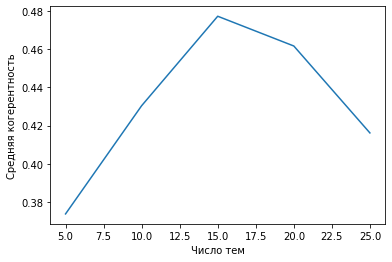

In [48]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [49]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
